# Train segmentation model
This notebook uses the simulated and real data to train the segmentation model used by the pipeline

## Usage:
Run all cells

## Requirements:
./content/datasets/h5_out/raw_image_real.h5\
./content/datasets/h5_out/raw_image_sim.h5\
./content/datasets/h5_out/semantic_id_list_real.h5\
./content/datasets/h5_out/semantic_id_list_sim.h5

Please refer to [KITTI pre-processing 11] to produce h5_out data

## Outputs:

./content/Model_weights.hdf5

In [ ]:
import h5py
import numpy as np
import PIL.Image as Image
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
from transformers import  TFSegformerForSemanticSegmentation,SegformerFeatureExtractor
from PIL import Image
import requests
from IPython.display import clear_output

In [2]:
def load_h5_to_dictionary(file_path):
    data_dict = {}
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            array_list = []
            group = hf[key]
            for dataset_name in group.keys():
                array_list.append(np.array(group[dataset_name]))
            data_dict[key] = array_list
    return data_dict

def find_lowest_dimensions(images_list1, images_list2):
    lowest_height = min(images_list1[0].shape[0], images_list2[0].shape[0])
    lowest_width = min(images_list1[0].shape[1], images_list2[0].shape[1])
    return lowest_height, lowest_width

def crop_images_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width,:] for image in images_list]
    return cropped_images

def crop_1d_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width] for image in images_list]
    return cropped_images

def map_to_desired_structure(input_image,output_image):
    return {'pixel_values': input_image, 'labels': output_image}

def map_values(value):
    if value in [1, 2, 6, 7, 8, 16, 21, 255]:
        return 1
    elif value in [11, 12]:
        return 2
    elif value in [13, 14, 15, 17]:
        return 3
    elif value == 10:
        return 4
    elif value == 0:
        return 0
    else:
        return 1 
    
def cast_to_uint8(value):
    return max(0, min(255, int(value)))

def create_tf_dataset(input_dict, output_dict, input_indices, input_dic_keys):
    input_images = []
    output_images = []

    
    for key in input_dic_keys:
      print("Dataset ",key)
      print("Elements number: ",len(input_indices[key]))
      for index in input_indices[key]:
        if index < len(input_dict[key]):
            if index!=0:
              input_images.append(input_dict[key][index])

    input_images = np.array(input_images)
    print(input_images.shape)
    input_images = tf.convert_to_tensor(input_images.astype(np.float16), np.float16)
    print(input_images.shape)
    input_images = tf.reverse(input_images, axis=[-1])
    input_images = tf.transpose(input_images, (0,3, 1, 2))

    
    vectorized_map = np.vectorize(map_values)
    for key in input_dic_keys:
      print("Dataset outputs: ",key)
      for index in input_indices[key]:
        if index < len(output_dict[key]):
            label_value = output_dict[key][index]
            if index!=0:
              output_images.append(vectorized_map(label_value))
            if index==0:
                print(np.unique(label_value))
                print(np.unique(vectorized_map(label_value)))
    print("Processing")
    # Convert lists to numpy arrays
    
    output_images = np.array(output_images)
    print(output_images.shape)
    print(np.unique(output_images))
    output_images = tf.convert_to_tensor(output_images.astype(np.float16), np.float16)

    # Create TensorFlow dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((input_images,output_images))
    print("Mapping")
    for samples in dataset.take(1):
        print(np.unique(samples[1]))
    dataset = dataset.map(map_to_desired_structure)
    for samples in dataset.take(1):
        print(np.unique(samples['labels']))
    for samples in dataset.take(1):
        print(np.unique(samples['pixel_values']))

    return dataset

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask","diff"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        print(display_list[i].shape)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

In [3]:
file_path = './content/content/h5_out/raw_image_sim.h5'
loaded_dictionary_images_sim=load_h5_to_dictionary(file_path)
file_path = './content/content/h5_out/raw_image_real.h5'
loaded_dictionary_images_real=load_h5_to_dictionary(file_path)
file_path = './content/content/h5_out/semantic_id_list_sim.h5'
loaded_semantic_id_sim=load_h5_to_dictionary(file_path)
file_path = './content/content/h5_out/semantic_id_list_real.h5'
loaded_semantic_id_real=load_h5_to_dictionary(file_path)
desired_semantic_id = 0
dataset_index_list_test=["0001","0002","0006","0018","0020"]



In [ ]:
lowest_height=10000
lowest_width=10000
for dataset_index in dataset_index_list_test:
  # height, width = find_lowest_dimensions(loaded_dictionary_images_real[dataset_index], loaded_dictionary_images_sim[dataset_index])
  height, width = find_lowest_dimensions(loaded_dictionary_images_real[dataset_index], loaded_dictionary_images_real[dataset_index])
  lowest_height=min(height,lowest_height)
  lowest_width=min(width,lowest_width)
print(lowest_height,lowest_width)


for dataset_index in dataset_index_list_test:

    loaded_dictionary_images_real[dataset_index] = crop_images_to_lowest_dimensions(loaded_dictionary_images_real[dataset_index], lowest_height, lowest_width)

    loaded_dictionary_images_sim[dataset_index] = crop_images_to_lowest_dimensions(loaded_dictionary_images_sim[dataset_index], lowest_height, lowest_width)

    loaded_semantic_id_real[dataset_index] = crop_1d_to_lowest_dimensions(loaded_semantic_id_real[dataset_index], lowest_height, lowest_width)
    
    loaded_semantic_id_sim[dataset_index] = crop_1d_to_lowest_dimensions(loaded_semantic_id_sim[dataset_index], lowest_height, lowest_width)

train_indexes_gan = {}
test_indexes_gan = {}

pattern = 'vvtvvtvvtv'
pattern_pointer = 0
for dataset_index in dataset_index_list_test:
  train_dataset_indices_inner = []
  test_dataset_indices_inner = []
  for index in range(0, min(len(loaded_dictionary_images_real[dataset_index]),len(loaded_dictionary_images_sim[dataset_index]))):
    pattern_char = pattern[pattern_pointer]
    if pattern_char == 't':
        train_dataset_indices_inner.append(index)
    else:
        test_dataset_indices_inner.append(index)
    pattern_pointer = (pattern_pointer + 1) % len(pattern)
  train_indexes_gan[dataset_index]=train_dataset_indices_inner
  test_indexes_gan[dataset_index]=test_dataset_indices_inner

print("GAN train and test")
for dataset_index in dataset_index_list_test:
    print("Dataset", dataset_index)
    print("Train: ",len(train_indexes_gan[dataset_index]))
    print("Trest: ",len(test_indexes_gan[dataset_index]))

tf_dataset_train_real = create_tf_dataset(loaded_dictionary_images_real, loaded_semantic_id_real, train_indexes_gan,dataset_index_list_test)
tf_dataset_test_real = create_tf_dataset(loaded_dictionary_images_real, loaded_semantic_id_real, test_indexes_gan,dataset_index_list_test)
tf_dataset_train_sim = create_tf_dataset(loaded_dictionary_images_sim, loaded_semantic_id_sim, train_indexes_gan,dataset_index_list_test)
tf_dataset_test_sim = create_tf_dataset(loaded_dictionary_images_sim, loaded_semantic_id_sim, test_indexes_gan,dataset_index_list_test)

train_dataset =tf_dataset_train_real

test_dataset =tf_dataset_test_real

train_dataset2 =tf_dataset_train_sim
test_dataset2 =tf_dataset_test_sim

dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
print("Size of the segmentation train dataset:", dataset_size)

dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()
print("Size of the GAN test dataset (Real or Fake):", dataset_size)

In [5]:
auto = tf.data.AUTOTUNE
batch_size = 4

train_ds = (
    train_dataset
    .cache()
    .shuffle(batch_size * 10)
    .batch(batch_size)
    .prefetch(auto)
)

test_ds = (
    test_dataset
    .batch(batch_size)
    .prefetch(auto)
)
train_ds2 = (
    train_dataset2
    .cache()
    .shuffle(batch_size * 10)
    .batch(batch_size)
    .prefetch(auto)
)

test_ds2 = (
    test_dataset2
    .batch(batch_size)
    .prefetch(auto)
)

Real gan test
(374, 1238, 3)
(374, 1238, 1)


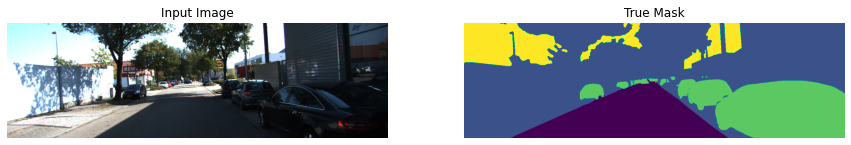

(374, 1238, 3)
(374, 1238, 1)


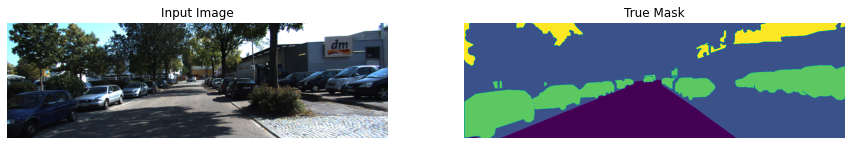

(374, 1238, 3)
(374, 1238, 1)


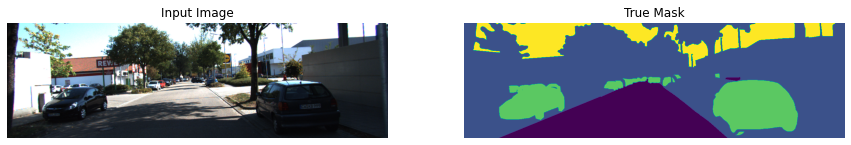

(374, 1238, 3)
(374, 1238, 1)


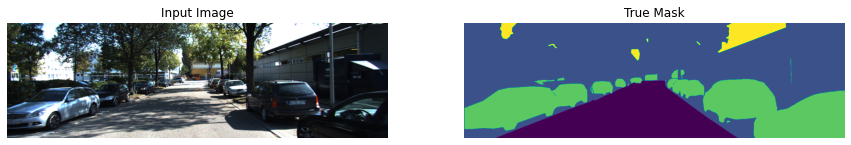

(374, 1238, 3)
(374, 1238, 1)


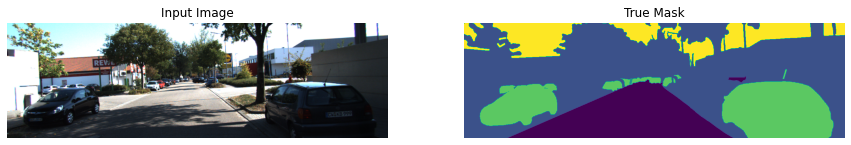

In [13]:

for samples in test_ds.take(5):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]

    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])


In [15]:
model_checkpoint = "nvidia/segformer-b0-finetuned-cityscapes-640-1280"

id2label = {0: 'Road', 1: 'Environment', 2: 'Person', 3: 'Vehicle', 4: 'Sky'}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
print(len(id2label))
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]
    
def cast_to_int32(image):
    # Normalize the image pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Convert to uint8 by scaling the values back to [0, 255]
    image = tf.cast(image * 255, tf.int32)
    return image

def calculate_pixel_difference(mask1, mask2):
    # Calculate the absolute difference between the two masks
    abs_diff = tf.abs(cast_to_uint8(mask1) - cast_to_uint8(mask2))
    # Sum up the pixel differences to get the total pixel difference
    pixel_difference = tf.reduce_sum(abs_diff)
    return pixel_difference
    

desired_semantic_id=0
def show_predictions(dataset=None, num=1):
    if dataset:
        dataset = dataset.shuffle(buffer_size=1000)
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            created_mask=cast_to_int32(create_mask(pred_masks))
            created_mask = tf.image.resize(created_mask, [374, 1238],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            gt=cast_to_int32(masks[0])
            diff_mask_road=abs(created_mask-gt)
            display([images[0], gt,created_mask,diff_mask_road ])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [ ]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)
checkpoint_file_path = "./content/segmentaion_checkpoints/Model_weights.hdf5"
model.load_weights(checkpoint_file_path)

CheckpointCallback = ModelCheckpoint("./content/Model_weights_cityscapes_mapped_with1.hdf5", verbose=1, monitor='val_loss', save_best_only=True,save_weights_only=True)
epoch_loops=10
for epoch_loop in range(0,epoch_loops):
    epochs = 1
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        callbacks=[DisplayCallback(test_ds), CheckpointCallback],
        epochs=epochs,
    )
    history = model.fit(
        train_ds2,
        validation_data=test_ds2,
        callbacks=[DisplayCallback(test_ds), CheckpointCallback],
        epochs=epochs,
    )

checkpoint_file_path = "./content/Model_weights.hdf5"
model.save_weights(checkpoint_file_path)

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


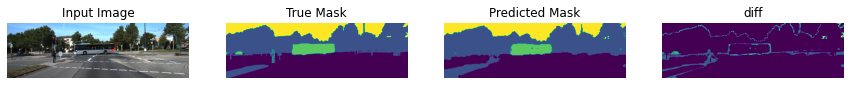

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


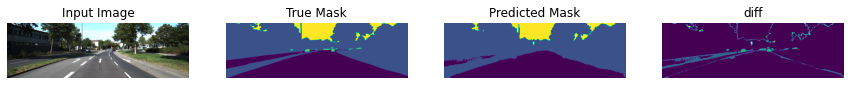

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


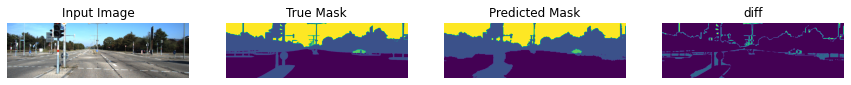

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


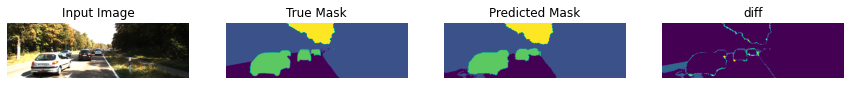

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


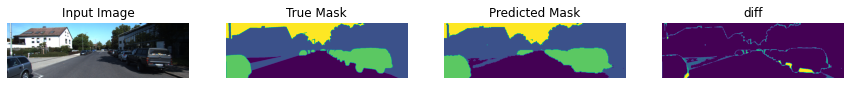

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


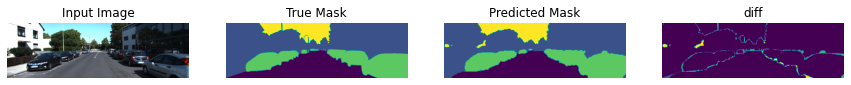

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


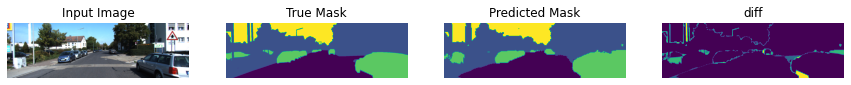

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


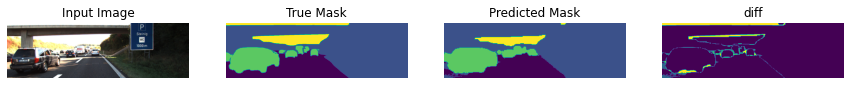

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


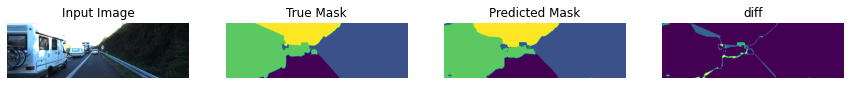

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


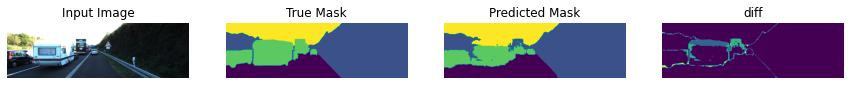

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


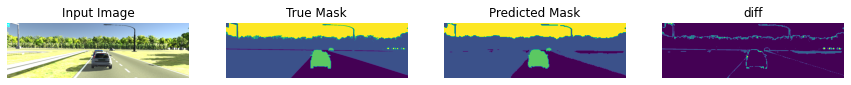

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


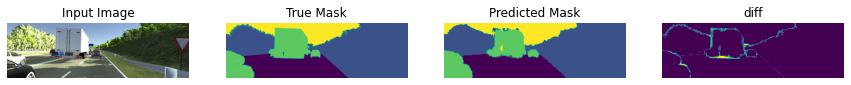

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


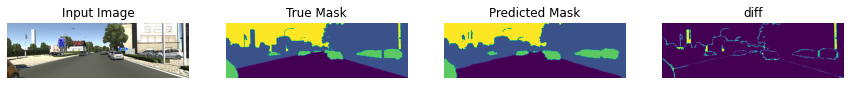

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


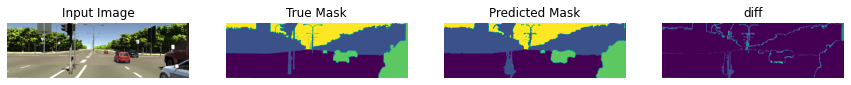

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


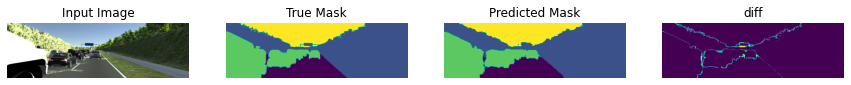

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


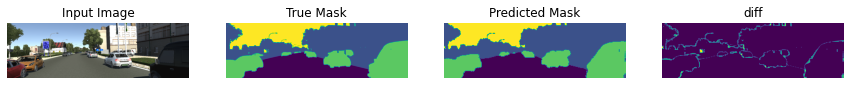

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


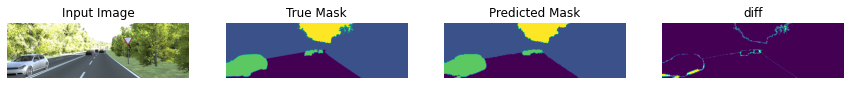

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


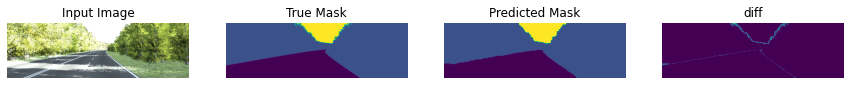

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


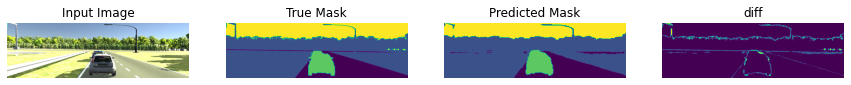

(374, 1238, 3)
(374, 1238, 1)
(374, 1238, 1)
(374, 1238, 1)


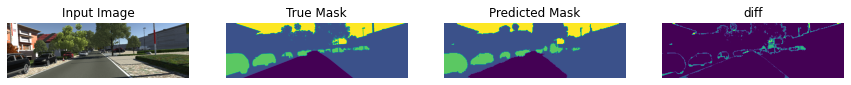

In [21]:
show_predictions(test_ds,10)
show_predictions(test_ds2,10)